In [ ]:
#############################RandomAgumentation##############################

import random
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image

# Define all augmentations
def ShearX(img, v):
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))

def ShearY(img, v):
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))

def TranslateX(img, v):
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

def TranslateY(img, v):
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

def Rotate(img, v):
    assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)

def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)

def Invert(img, _):
    return PIL.ImageOps.invert(img)

def Equalize(img, _):
    return PIL.ImageOps.equalize(img)

def Flip(img, _):
    return PIL.ImageOps.mirror(img)

def Solarize(img, v):
    assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)

def Posterize(img, v):
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)

def Contrast(img, v):
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)

def Color(img, v):
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)

def Brightness(img, v):
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)

def Sharpness(img, v):
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)

def Cutout(img, v):
    assert 0.0 <= v <= 0.2
    if v <= 0.:
        return img
    v = v * img.size[0]
    return CutoutAbs(img, v)

def CutoutAbs(img, v):
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)
    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)
    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img

def augment_list():
    return [
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (TranslateX, 0., 0.45),
        (TranslateY, 0., 0.45),
        (Cutout, 0., 0.2)
    ]

class RandAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)
        return img


In [ ]:
################################# CIFAR-10 and CIFAR-100 dataloader#################################
import torch
import torchvision
import torchvision.transforms as transforms
#from randomaug import RandAugment
import matplotlib.pyplot as plt


def get_loaders_CIFAR10(size, batch_size, aug=True, N=2, M=14):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.Resize(size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    transform_test = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    if aug:
        transform_train.transforms.insert(0, RandAugment(N, M))

    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=8
    )

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=100, shuffle=False, num_workers=8
    )

    return trainloader, testloader


def get_loaders_CIFAR100(size, batch_size, aug=True, N=2, M=14):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.Resize(size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

    transform_test = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

    if aug:
        transform_train.transforms.insert(0, RandAugment(N, M))

    trainset = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=transform_train
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=8
    )

    testset = torchvision.datasets.CIFAR100(
        root='./data', train=False, download=True, transform=transform_test
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=100, shuffle=False, num_workers=8
    )

    return trainloader, testloader






In [ ]:
################################ Swin Transformer ################################
import torch
from torch import nn, einsum
import numpy as np
from einops import rearrange, repeat


class CyclicShift(nn.Module):
    def __init__(self, displacement):
        super().__init__()
        self.displacement = displacement

    def forward(self, x):
        return torch.roll(x, shifts=(self.displacement, self.displacement), dims=(1, 2))


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)


def create_mask(window_size, displacement, upper_lower, left_right):
    mask = torch.zeros(window_size ** 2, window_size ** 2)

    if upper_lower:
        mask[-displacement * window_size:, :-displacement * window_size] = float('-inf')
        mask[:-displacement * window_size, -displacement * window_size:] = float('-inf')

    if left_right:
        mask = rearrange(mask, '(h1 w1) (h2 w2) -> h1 w1 h2 w2', h1=window_size, h2=window_size)
        mask[:, -displacement:, :, :-displacement] = float('-inf')
        mask[:, :-displacement, :, -displacement:] = float('-inf')
        mask = rearrange(mask, 'h1 w1 h2 w2 -> (h1 w1) (h2 w2)')

    return mask


def get_relative_distances(window_size):
    indices = torch.tensor(np.array([[x, y] for x in range(window_size) for y in range(window_size)]))
    distances = indices[None, :, :] - indices[:, None, :]
    return distances


class WindowAttention(nn.Module):
    def __init__(self, dim, heads, head_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        inner_dim = head_dim * heads

        self.heads = heads
        self.scale = head_dim ** -0.5
        self.window_size = window_size
        self.relative_pos_embedding = relative_pos_embedding
        self.shifted = shifted

        if self.shifted:
            displacement = window_size // 2
            self.cyclic_shift = CyclicShift(-displacement)
            self.cyclic_back_shift = CyclicShift(displacement)
            self.upper_lower_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                             upper_lower=True, left_right=False), requires_grad=False)
            self.left_right_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                            upper_lower=False, left_right=True), requires_grad=False)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        if self.relative_pos_embedding:
            self.relative_indices = get_relative_distances(window_size) + window_size - 1
            self.pos_embedding = nn.Parameter(torch.randn(2 * window_size - 1, 2 * window_size - 1))
        else:
            self.pos_embedding = nn.Parameter(torch.randn(window_size ** 2, window_size ** 2))

        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        if self.shifted:
            x = self.cyclic_shift(x)

        b, n_h, n_w, _, h = *x.shape, self.heads

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        nw_h = n_h // self.window_size
        nw_w = n_w // self.window_size

        q, k, v = map(
            lambda t: rearrange(t, 'b (nw_h w_h) (nw_w w_w) (h d) -> b h (nw_h nw_w) (w_h w_w) d',
                                h=h, w_h=self.window_size, w_w=self.window_size), qkv)

        dots = einsum('b h w i d, b h w j d -> b h w i j', q, k) * self.scale

        if self.relative_pos_embedding:
            dots += self.pos_embedding[self.relative_indices[:, :, 0], self.relative_indices[:, :, 1]]
        else:
            dots += self.pos_embedding

        if self.shifted:
            dots[:, :, -nw_w:] += self.upper_lower_mask
            dots[:, :, nw_w - 1::nw_w] += self.left_right_mask

        attn = dots.softmax(dim=-1)

        out = einsum('b h w i j, b h w j d -> b h w i d', attn, v)
        out = rearrange(out, 'b h (nw_h nw_w) (w_h w_w) d -> b (nw_h w_h) (nw_w w_w) (h d)',
                        h=h, w_h=self.window_size, w_w=self.window_size, nw_h=nw_h, nw_w=nw_w)
        out = self.to_out(out)

        if self.shifted:
            out = self.cyclic_back_shift(out)
        return out


class SwinBlock(nn.Module):
    def __init__(self, dim, heads, head_dim, mlp_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        self.attention_block = Residual(PreNorm(dim, WindowAttention(dim=dim,
                                                                     heads=heads,
                                                                     head_dim=head_dim,
                                                                     shifted=shifted,
                                                                     window_size=window_size,
                                                                     relative_pos_embedding=relative_pos_embedding)))
        self.mlp_block = Residual(PreNorm(dim, FeedForward(dim=dim, hidden_dim=mlp_dim)))

    def forward(self, x):
        x = self.attention_block(x)
        x = self.mlp_block(x)
        return x


class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, downscaling_factor):
        super().__init__()
        self.downscaling_factor = downscaling_factor
        self.patch_merge = nn.Unfold(kernel_size=downscaling_factor, stride=downscaling_factor, padding=0)
        self.linear = nn.Linear(in_channels * downscaling_factor ** 2, out_channels)

    def forward(self, x):
        b, c, h, w = x.shape
        new_h, new_w = h // self.downscaling_factor, w // self.downscaling_factor
        x = self.patch_merge(x).view(b, -1, new_h, new_w).permute(0, 2, 3, 1)
        x = self.linear(x)
        return x


class StageModule(nn.Module):
    def __init__(self, in_channels, hidden_dimension, layers, downscaling_factor, num_heads, head_dim, window_size,
                 relative_pos_embedding):
        super().__init__()
        assert layers % 2 == 0, 'Stage layers need to be divisible by 2 for regular and shifted block.'

        self.patch_partition = PatchMerging(in_channels=in_channels, out_channels=hidden_dimension,
                                            downscaling_factor=downscaling_factor)

        self.layers = nn.ModuleList([])
        for _ in range(layers // 2):
            self.layers.append(nn.ModuleList([
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=False, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=True, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
            ]))

    def forward(self, x):
        x = self.patch_partition(x)
        for regular_block, shifted_block in self.layers:
            x = regular_block(x)
            x = shifted_block(x)
        return x.permute(0, 3, 1, 2)


class SwinTransformer(nn.Module):
    def __init__(self, *, hidden_dim, layers, heads, channels=3, num_classes=1000, head_dim=32, window_size=7,
                 downscaling_factors=(4, 2, 2, 2), relative_pos_embedding=True):
        super().__init__()

        self.stage1 = StageModule(in_channels=channels, hidden_dimension=hidden_dim, layers=layers[0],
                                  downscaling_factor=downscaling_factors[0], num_heads=heads[0], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage2 = StageModule(in_channels=hidden_dim, hidden_dimension=hidden_dim * 2, layers=layers[1],
                                  downscaling_factor=downscaling_factors[1], num_heads=heads[1], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage3 = StageModule(in_channels=hidden_dim * 2, hidden_dimension=hidden_dim * 4, layers=layers[2],
                                  downscaling_factor=downscaling_factors[2], num_heads=heads[2], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage4 = StageModule(in_channels=hidden_dim * 4, hidden_dimension=hidden_dim * 8, layers=layers[3],
                                  downscaling_factor=downscaling_factors[3], num_heads=heads[3], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_dim * 8),
            nn.Linear(hidden_dim * 8, num_classes)
        )

    def forward(self, img):
        x = self.stage1(img)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = x.mean(dim=[2, 3])
        return self.mlp_head(x)


def swin_t(hidden_dim=96, layers=(2, 2, 6, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


def swin_s(hidden_dim=96, layers=(2, 2, 18, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


def swin_b(hidden_dim=128, layers=(2, 2, 18, 2), heads=(4, 8, 16, 32), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


def swin_l(hidden_dim=192, layers=(2, 2, 18, 2), heads=(6, 12, 24, 48), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


# To summarize, your swin_transformer.py defines:
# - SwinTransformer
# - swin_t (tiny)
# - swin_s (small)
# - swin_b (base)
# - swin_l (large)

# It is fully ready!

# Example (for your reference):
# from swin_transformer import swin_t

# model = swin_t(
#     hidden_dim=96,
#     layers=(2, 2, 6, 2),
#     heads=(3, 6, 12, 24),
#     channels=3,
#     num_classes=10,
#     head_dim=32,
#     window_size=4,
#     downscaling_factors=(2, 2, 2, 1),
#     relative_pos_embedding=True
# )

100%|██████████| 170M/170M [00:01<00:00, 88.9MB/s]



Epoch: 0


<ipython-input-4-066df6f34a8a>:228: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=not args.noamp and device == 'cuda')
<ipython-input-4-066df6f34a8a>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Train Loss: 2.3085 | Train Acc: 13.54%
Test Loss: 2.1577 | Test Acc: 21.60%
Saving checkpoint..

Epoch: 1
Train Loss: 2.2489 | Train Acc: 15.66%
Test Loss: 2.1284 | Test Acc: 18.67%

Epoch: 2
Train Loss: 2.1751 | Train Acc: 18.70%
Test Loss: 1.9778 | Test Acc: 25.54%
Saving checkpoint..

Epoch: 3
Train Loss: 2.0835 | Train Acc: 22.98%
Test Loss: 1.8972 | Test Acc: 29.75%
Saving checkpoint..

Epoch: 4
Train Loss: 2.0097 | Train Acc: 26.06%
Test Loss: 1.8568 | Test Acc: 32.29%
Saving checkpoint..

Epoch: 5
Train Loss: 1.9375 | Train Acc: 28.61%
Test Loss: 1.7748 | Test Acc: 34.69%
Saving checkpoint..

Epoch: 6
Train Loss: 1.8449 | Train Acc: 32.26%
Test Loss: 1.6071 | Test Acc: 41.28%
Saving checkpoint..

Epoch: 7
Train Loss: 1.7629 | Train Acc: 35.86%
Test Loss: 1.5208 | Test Acc: 44.29%
Saving checkpoint..

Epoch: 8
Train Loss: 1.6965 | Train Acc: 38.51%
Test Loss: 1.4666 | Test Acc: 46.35%
Saving checkpoint..

Epoch: 9
Train Loss: 1.6596 | Train Acc: 39.50%
Test Loss: 1.4391 | Test Ac

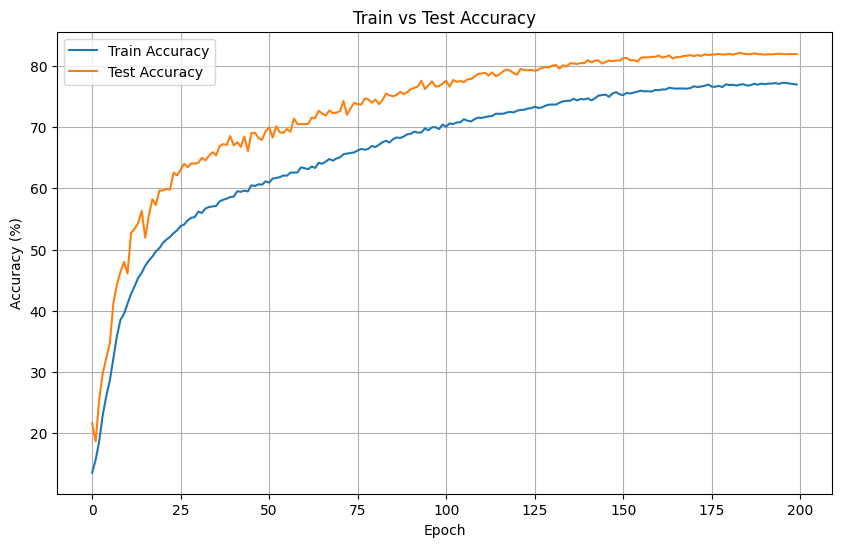

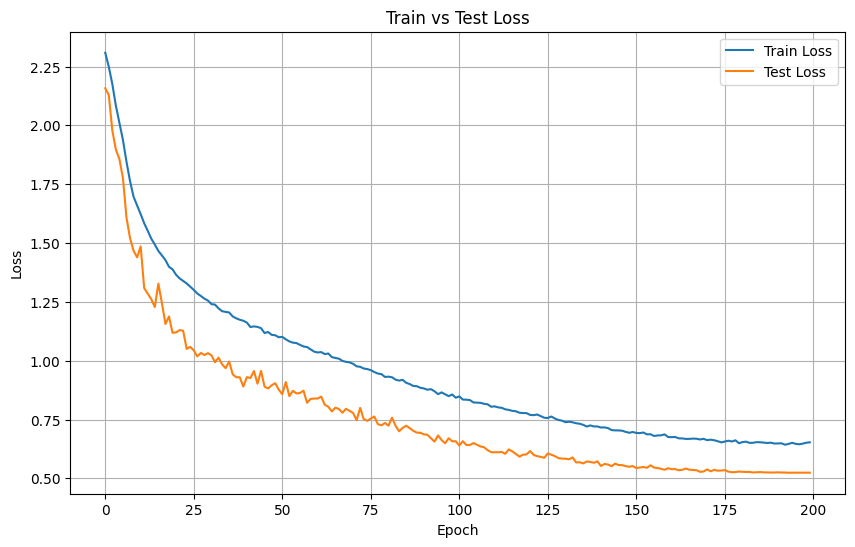

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt

#from swin_transformer import swin_t
#from custom_loader import get_loaders_CIFAR100  # Update this to your actual data loader file
#from custom_plotting import plot_training  # Or replace with your local function as defined below


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train(epoch, net, trainloader, criterion, optimizer, scaler, use_amp, device):
    print(f'\nEpoch: {epoch}')
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = net(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100. * correct / total
    print(f'Train Loss: {train_loss / len(trainloader):.4f} | Train Acc: {acc:.2f}%')
    return train_loss / len(trainloader), acc


def test(epoch, net, testloader, criterion, optimizer, scaler, best_acc, args, device):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100. * correct / total
    print(f'Test Loss: {test_loss / len(testloader):.4f} | Test Acc: {acc:.2f}%')

    if acc > best_acc:
        print('Saving checkpoint..')
        state = {
            'model': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'optimizer': optimizer.state_dict(),
            'scaler': scaler.state_dict()
        }
        os.makedirs('checkpoint', exist_ok=True)
        torch.save(state, f'./checkpoint/{args.net}-{args.patch}-ckpt.t7')
        best_acc = acc

    return test_loss/ len(testloader), acc, best_acc

def plot_accuracy(train_acc, val_acc):
    train_acc = [x.item() if torch.is_tensor(x) else x for x in train_acc]
    val_acc = [x.item() if torch.is_tensor(x) else x for x in val_acc]
    plt.figure(figsize=(10, 6))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Train vs Test Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig('accuracy_plot.png')
    plt.show()


def plot_loss(train_loss, val_loss):
    train_loss = [x.item() if torch.is_tensor(x) else x for x in train_loss]
    val_loss = [x.item() if torch.is_tensor(x) else x for x in val_loss]
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_plot.png')
    plt.show()


def plot_training(train_losses, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train & Test Loss By Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy By Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()


def visualize_predictions(net, testloader, classes, num_samples=5, epoch=0, device='cuda'):
    net.eval()
    all_images = []
    all_labels = []

    for images, labels in testloader:
        all_images.append(images)
        all_labels.append(labels)

    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    idx = np.random.choice(len(all_images), num_samples, replace=False)
    images = all_images[idx]
    labels = all_labels[idx]

    images = images.to(device)
    with torch.no_grad():
        outputs = net(images)
        _, preds = outputs.max(1)

    images = images.cpu()
    preds = preds.cpu()
    labels = labels.cpu()

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        img = images[i]
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.2023, 0.1994, 0.2010]) + torch.tensor([0.4914, 0.4822, 0.4465])
        img = img.numpy()
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"P: {classes[preds[i]]}\nT: {classes[labels[i]]}", fontsize=6)

    os.makedirs('sample_predictions', exist_ok=True)
    save_path = f'sample_predictions/epoch_{epoch}.png'
    plt.tight_layout(pad=0.1)
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.close()
    print(f"Saved sample predictions at: {save_path}")


def main():
    args = type('', (), {})()
    args.dataset = 'CIFAR10'
    args.dataset_classes = 10
    args.lr = 1e-4
    args.opt = 'adam'
    args.resume = True
    args.noaug = False
    args.noamp = False
    args.dp = True
    args.net = 'swin'
    args.heads = 6
    args.layers = 12
    args.bs = 64
    args.size = 32
    args.n_epochs = 200  # or however many you want
    args.patch = 4
    args.dimhead = 420

    best_acc = 0
    start_epoch = 0
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # ✅ Load CIFAR-100 data and class names
    trainloader, testloader = get_loaders_CIFAR10(args.size, args.bs, aug=not args.noaug)
    classes = torchvision.datasets.CIFAR10(root='./data', train=False).classes

    net = swin_t(
        hidden_dim=96,
        layers=(2, 2, 6, 2),
        heads=(3, 6, 12, 24),
        channels=3,
        num_classes=args.dataset_classes,
        head_dim=args.dimhead,
        window_size=args.patch,
        downscaling_factors=(2, 2, 2, 1),
    )

    if args.dp and torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
        net = nn.DataParallel(net)

    net = net.to(device)
    criterion = nn.CrossEntropyLoss()

    if args.opt == 'adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr)
    else:
        optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)

    scaler = torch.cuda.amp.GradScaler(enabled=not args.noamp and device == 'cuda')
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.n_epochs)

    # ✅ Resume logic
    if args.resume:
        checkpoint_path = f'./checkpoint/{args.net}-{args.patch}-ckpt.t7'
        if os.path.exists(checkpoint_path):
            try:
                print(f"Resuming from checkpoint {checkpoint_path}...")
                checkpoint = torch.load(checkpoint_path, map_location=device)
                net.load_state_dict(checkpoint['model'])
                if 'optimizer' in checkpoint and 'scaler' in checkpoint:
                    optimizer.load_state_dict(checkpoint['optimizer'])
                    scaler.load_state_dict(checkpoint['scaler'])
                start_epoch = checkpoint.get('epoch', 0) + 1
                best_acc = checkpoint.get('acc', 0)
                print(f"Resumed at epoch {start_epoch} with best accuracy {best_acc:.2f}%")
            except Exception as e:
                print(f"Failed to load checkpoint: {e}")
                print("Training from scratch instead.")
    else:
        print("No checkpoint found. Training from scratch.")


    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(start_epoch, args.n_epochs):
        train_loss, train_acc = train(epoch, net, trainloader, criterion, optimizer, scaler, use_amp=not args.noamp, device=device)
        test_loss, test_acc, best_acc = test(epoch, net, testloader, criterion, optimizer, scaler, best_acc, args, device)
        scheduler.step()

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # ✅ Visualize predictions every 10 epochs or at last epoch
        if (epoch + 1) % 10 == 0 or (epoch + 1) == args.n_epochs:
            visualize_predictions(net, testloader, classes, num_samples=5, epoch=epoch + 1, device=device)

    #plot_training(train_losses, test_losses, test_accuracies)
    plot_accuracy(train_accuracies, test_accuracies)
    plot_loss(train_losses, test_losses)


if __name__ == '__main__':
    main()
